In [480]:
import pandas as pd
import vertica_python
import sqlalchemy as sa
%matplotlib inline

In [481]:
# engine_info = "vertica+vertica_python://" + conn_info['user'] + ":" + conn_info['password'] + "@" + "vertica.getbux.com" + ":5433/" + conn_info['database'] 
# engine = sa.create_engine(engine_info)


# cur = connection.cursor()
# cur.execute("SELECT * FROM TABLE")
# result = cur.fetchall()
# connection.close()

# from sqlalchemy.engine import url as sa_url
# from sqlalchemy import create_engine
# db_connect_url = sa_url.URL(
#             drivername='vertica+pyodbc',
#             username='josolnik',
#             password='CXw!CHeDa@N6hGQ8',
#             host='vertica.getbux.com',
#             port=5433,
#             database='buxdwh',
# )
# create_engine(db_connect_url)

In [482]:
conn_info = {'host': 'vertica.getbux.com',
              'port': 5433,
              'user': 'josolnik',
              'password': 'CXw!CHeDa@N6hGQ8',
              'database': 'buxdwh',
              # 10 minutes timeout on queries
              'read_timeout': 600,
              # default throw error on invalid UTF-8 results
              'unicode_error': 'strict',
              # SSL is disabled by default
              'ssl': False,
              'connection_timeout': 5
              # connection timeout is not enabled by default
           }

# # simple connection, with manual close
conn = vertica_python.connect(**conn_info)
cur = conn.cursor('dict')

In [483]:
def sql_query(query_string): # columns):
    cur.execute(query_string)
    df = pd.DataFrame(cur.fetchall())
    # df.columns = columns
    return df

### Users

In [569]:
user_columns = ['user_id', 'country_cd', 'gender', 'nationality', 'platform_type_name', 'trading_experience', 'title', 'network', 'bux_account_created_dts', 'account_type', 'ams_first_funded_dts', 'initial_deposit_amount', 'sum_deposits', 'cnt_deposits']

query_users = """ 

        SELECT user_id, country_cd, gender, nationality, platform_type_name, trading_experience, title, network, bux_account_created_dts, account_type, ams_first_funded_dts, initial_deposit_amount, sum_deposits, cnt_deposits
        FROM reporting.user_details
        WHERE bux_account_created_dts::date BETWEEN '2017-02-01' AND '2017-02-10'

        """
users = sql_query(query_users)
# users.columns = user_columns

In [570]:
users.head()

,user_id,country_cd,gender,nationality,platform_type_name,trading_experience,title,network,bux_account_created_dts,account_type,ams_first_funded_dts,initial_deposit_amount,sum_deposits,cnt_deposits
0,003921b6-3e01-4627-9f9f-db0afb3b61ac,AT,None,None,Android,NONE,Rookie Trader,Viral Invites,2017-02-03 19:57:46.880,FUN_BUX,NaT,None,None,NaN
1,014d54d1-606a-40ba-bfda-d217615dc74f,AT,None,None,Android,NONE,Rookie Trader,Viral Invites,2017-02-07 11:12:24.184,FUN_BUX,NaT,None,None,NaN
2,01e07150-b18b-457b-9c7a-697132b9120a,AT,None,None,Android,NONE,Rookie Trader,Facebook Installs,2017-02-03 22:21:10.140,FUN_BUX,NaT,None,None,NaN
3,01f17ed7-73a7-4b22-aac7-5d1eef7767be,AT,None,None,Android,NONE,Rookie Trader,TV,2017-02-08 12:39:52.748,FUN_BUX,NaT,None,None,NaN
4,01f4cc6c-088d-44c5-a350-fb44956cb266,AT,None,None,Android,SOME,Experienced Trader,Viral Invites,2017-02-09 22:41:20.146,FUN_BUX,NaT,None,None,NaN


In [572]:
users.to_csv('data/users_Feb_1_10days_cohort.csv')

In [573]:
len(users)

21677

### USERS EDA

In [497]:
def column_summary(column_name, limit=False):
    if limit:
        df = pd.DataFrame(users[column_name].value_counts()).sort_values(by=column_name, ascending=False)[0:limit]
        plot = df.plot(kind='bar')
        return plot, df

,sum_deposits
50.0000000,252
100.0000000,104
150.0000000,43
200.0000000,43
250.0000000,26
300.0000000,23
500.0000000,14
400.0000000,14
450.0000000,10
1000.0000000,10


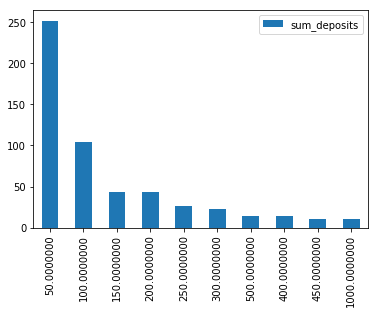

In [498]:
df, plot = column_summary('sum_deposits', 10);
df
plot

,account_type
FUN_BUX,21090
SERIOUS_BUX,587


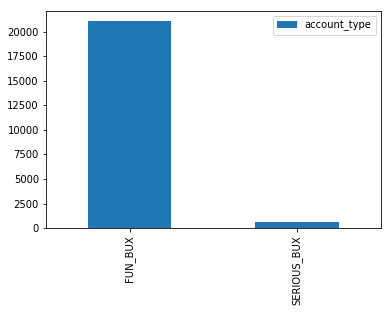

In [574]:
df, plot = column_summary('account_type',10)
df
plot

,network
Facebook Installs,5489
Organic,4801
TV,4704
Viral Invites,3834
Instagram Installs,594
Appnext,578
Google Adwords Search,401
BUX Website,290
Ligatus,202
Google Universal App Campaigns,194


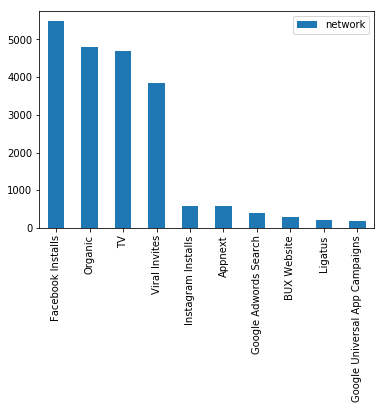

In [575]:
df, plot = column_summary('network',10)
df
plot

,trading_experience
NONE,17051
SOME,4625
EXPERT,1


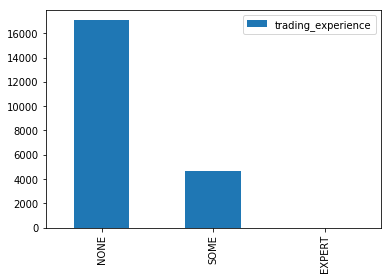

In [576]:
df, plot = column_summary('trading_experience',10)
df
plot

,gender
MALE,2675
FEMALE,160


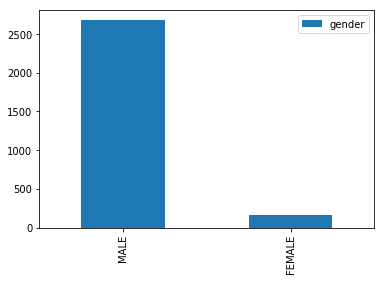

In [577]:
df, plot = column_summary('gender',10)
df
plot

### Transactions (cube_daily_user)

Daily transaction aggragation of user transactions

In [578]:
user_ids = tuple(users['user_id'].unique())

In [579]:
sample_user_ids = tuple(users[:5]['user_id'])
# str(sample_user_ids)
sample_user_ids

('003921b6-3e01-4627-9f9f-db0afb3b61ac',
 '014d54d1-606a-40ba-bfda-d217615dc74f',
 '01e07150-b18b-457b-9c7a-697132b9120a',
 '01f17ed7-73a7-4b22-aac7-5d1eef7767be',
 '01f4cc6c-088d-44c5-a350-fb44956cb266')

In [580]:
daily_cube_columns = ['user_id', 'day_of_year', 'date', 'number_of_sessions', 'total_session_duration', 'account_status', 'trades_fb_commodities_open', 'trades_fb_commodities_profit', 'social_status_battles', 'social_status', 'conversion_to_sb']
daily_cube_columns = str(tuple(["a." + column for column in daily_cube_columns]))
daily_cube_columns = daily_cube_columns.replace('(', '').replace(')','').replace("'", "")
daily_cube_columns

'a.user_id, a.day_of_year, a.date, a.number_of_sessions, a.total_session_duration, a.account_status, a.trades_fb_commodities_open, a.trades_fb_commodities_profit, a.social_status_battles, a.social_status, a.conversion_to_sb'

### Query on a sample of users

query_trans = """

SELECT * FROM reporting.cube_daily_user WHERE user_id IN ('010e236f-8ab5-4681-a146-273531d19d54',
 '011f6526-ab7e-4790-b289-5fa1faf69bc3',
 '0231bd62-6733-4f8b-9c57-87f4eb9e0aa1',
 '028e03b9-ab6d-4ede-85f2-ce6b6e38ad47',
 '031eedbe-8154-4032-b9b7-157ac8131669') AND month = 2 AND year = 2017

"""

conn = vertica_python.connect(**conn_info)
cur = conn.cursor('dict')
cur.execute(query_trans)
df = pd.DataFrame(cur.fetchall())
df.head()

## Query on all users

In [581]:
len(users)

21677

sample_user_ids = tuple(users[:1000]['user_id'])
sample_user_ids[0:5]

In [582]:
daily_cube_columns

'a.user_id, a.day_of_year, a.date, a.number_of_sessions, a.total_session_duration, a.account_status, a.trades_fb_commodities_open, a.trades_fb_commodities_profit, a.social_status_battles, a.social_status, a.conversion_to_sb'

In [583]:
query_transactions = """

    SELECT a.user_id, a.day_of_year, a.date, a.number_of_sessions, a.total_session_duration, a.account_status, a.trades_fb_commodities_open, a.trades_fb_commodities_profit, a.social_status_battles, a.social_status, a.conversion_to_sb
    FROM reporting.cube_daily_user a 
    JOIN reporting.user_details b on b.user_id = a.user_id
    WHERE b.bux_account_created_dts::date  between '2017-02-01' and '2017-02-10'
    AND a.date between b.bux_account_created_dts::date and b.bux_account_created_dts::date + interval '3 weeks'
    

"""
query_transactions

"\n\n    SELECT a.user_id, a.day_of_year, a.date, a.number_of_sessions, a.total_session_duration, a.account_status, a.trades_fb_commodities_open, a.trades_fb_commodities_profit, a.social_status_battles, a.social_status, a.conversion_to_sb\n    FROM reporting.cube_daily_user a \n    JOIN reporting.user_details b on b.user_id = a.user_id\n    WHERE b.bux_account_created_dts::date  between '2017-02-01' and '2017-02-10'\n    AND a.date between b.bux_account_created_dts::date and b.bux_account_created_dts::date + interval '3 weeks'\n    \n\n"

In [515]:
conn = vertica_python.connect(**conn_info)
cur = conn.cursor('dict')
cur.execute(query_transactions)
cube_daily_user = pd.DataFrame(cur.fetchall())
cube_daily_user.head()

,user_id,day_of_year,date,number_of_sessions,total_session_duration,account_status,trades_fb_commodities_open,trades_fb_commodities_profit,social_status_battles,social_status,conversion_to_sb
0,000a8509-5100-4f81-9487-85b71f77e2a6,41,2017-02-10,2,251,FUN_BUX,0,0.00,0,Non-Social,0
1,000a8509-5100-4f81-9487-85b71f77e2a6,42,2017-02-11,1,23,FUN_BUX,0,0.00,0,Non-Social,0
2,000a8509-5100-4f81-9487-85b71f77e2a6,44,2017-02-13,1,102,FUN_BUX,0,0.00,0,Non-Social,0
3,000a8509-5100-4f81-9487-85b71f77e2a6,50,2017-02-19,1,19,FUN_BUX,0,0.00,0,Non-Social,0
4,000a8509-5100-4f81-9487-85b71f77e2a6,54,2017-02-23,1,7897,FUN_BUX,0,0.00,0,Non-Social,0


In [516]:
len(cube_daily_user['user_id'].unique())

21410

In [517]:
len(cube_daily_user)

136681

In [518]:
len(cube_daily_user['user_id'].unique())

21410

In [520]:
cube_daily_user.to_csv('data/cube_daily_user_Feb_1_10days_cohort.csv')

In [521]:
pd.Series(cube_daily_user.columns)

0                          user_id
1                      day_of_year
2                             date
3               number_of_sessions
4           total_session_duration
5                   account_status
6       trades_fb_commodities_open
7     trades_fb_commodities_profit
8            social_status_battles
9                    social_status
10                conversion_to_sb
dtype: object

In [522]:
cube_daily_user.groupby('user_id').mean()

,day_of_year,number_of_sessions,total_session_duration,trades_fb_commodities_open,social_status_battles,conversion_to_sb
user_id,,,,,,
0001a0b6-fe20-47d2-a9f9-dde0af2ee132,40.000000,1.000000,661.000000,0.000000,0.000000,0.000000
00028e09-fcff-4368-9409-e9419efec176,38.000000,2.000000,256.000000,0.000000,0.000000,0.000000
0008181d-5863-4378-ba9a-00206346827b,41.000000,3.000000,8391.000000,0.000000,0.000000,0.000000
000a8509-5100-4f81-9487-85b71f77e2a6,46.200000,1.200000,1658.400000,0.000000,0.000000,0.000000
000ce685-75a4-4490-81a0-2efb786f8c87,46.500000,2.000000,297.500000,0.000000,0.000000,0.000000
000fc4bb-5b31-41b6-92e9-463f6ccef66f,37.000000,1.000000,146.000000,0.000000,0.000000,0.000000
001c9415-fc54-4695-b28e-c96255d5a211,38.000000,4.000000,454.000000,0.000000,0.000000,0.000000
001d03b9-d220-46bc-82ca-2d3898b6f810,38.000000,5.000000,313.000000,0.000000,0.000000,0.000000
002215ea-efd4-4f4d-9e92-b5cfb847ae37,35.500000,3.000000,543.500000,0.000000,0.000000,0.000000


In [523]:
cube_daily_user.groupby('user_id')['number_of_sessions', 'total_session_duration', 'trades_fb_commodities_open'].mean()[0:5]

,number_of_sessions,total_session_duration,trades_fb_commodities_open
user_id,,,
0001a0b6-fe20-47d2-a9f9-dde0af2ee132,1.0,661.0,0.0
00028e09-fcff-4368-9409-e9419efec176,2.0,256.0,0.0
0008181d-5863-4378-ba9a-00206346827b,3.0,8391.0,0.0
000a8509-5100-4f81-9487-85b71f77e2a6,1.2,1658.4,0.0
000ce685-75a4-4490-81a0-2efb786f8c87,2.0,297.5,0.0


## Current customer value (CurCV))

In [524]:
query_curcv = """ 

        SELECT a.user_id, sum(b.commission) as com, sum(b.dividend) as div, sum(b.financing_fee) as ff
        FROM (
        
        SELECT user_id
        FROM reporting.user_details
        WHERE bux_account_created_dts::date BETWEEN '2017-02-01' AND '2017-02-10') a
        

        LEFT JOIN (
        
        
        SELECT
        user_id
        , created_dts::date as report_date
        , sum(decode(transaction_type, 'COMMISSION',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as commission
        , sum(decode(transaction_type, 'DIVIDEND',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as dividend
        , sum(decode(transaction_type, 'FINANCING_FEE',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as financing_fee
        from reporting.transactions a
        left join reporting.exchange_rates_eur b on b.report_date = a.created_dts::date and b.currency = a.currency
        group by 1,2
        order by 1 ) b
        
        ON a.user_id = b.user_id
        GROUP BY a.user_id

"""

CurCV = sql_query(query_curcv)
CurCV[0:5]

,user_id,com,div,ff
0,7c410fec-78b5-404c-9973-f7bc1c281f18,None,None,None
1,1cd5d031-6ce9-4d5f-ada6-0a99d614105a,None,None,None
2,ed3354d7-5212-4cca-9bfe-66e795b43c72,None,None,None
3,2a5f0a88-3081-426f-b841-fe03ec4319ed,None,None,None
4,1eef80d9-1c48-4dce-9146-db7c88e66cff,None,None,None


In [525]:
CurCV['total'] = curCv['com'] + curCv['div'] + curCv['ff']

In [530]:
import numpy as np

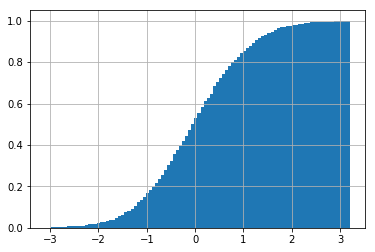

In [534]:
ser = pd.Series(np.random.normal(size=1000))
ser.hist(cumulative=True, normed=1, bins=100)

In [548]:
serious_buxers = curCv[pd.isnull(curCv['total']) == False]['total']

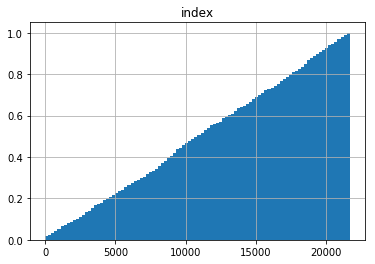

In [561]:
pd.DataFrame(serious_buxers).reset_index().hist(cumulative=True, normed=1, bins=100);

In [568]:
curCv.to_csv('data/curCv_Feb_1_10days_cohort')